**A brief overview of <span style="font-family: 'Courier New', Courier, monospace; font-weight: 700;">Xstack</span>**:

<span style="font-family: 'Courier New', Courier, monospace; font-weight: 700;">Xstack</span> is a open-source, light-weight code for **X-ray spectral shifting and stacking**. 

Given the **redshift** of each spectrum in a list, <span style="font-family: 'Courier New', Courier, monospace; font-weight: 700;">Xstack</span> will first shift these spectra *(PHA, counts vs. output energy (channel))* from observed-frame to rest-frame, and then sum them together. The response matrix files *(RMF, the probability that a photon with input energy $E_1$ will be detected with an output energy $E_2$)* and ancillary response files *(ARF, effective area vs. input energy)* are shifted and stacked in a similar way to the spectrum. <span style="font-family: 'Courier New', Courier, monospace; font-weight: 700;">Xstack</span> also supports correction of Galactic absorption, if an additional **NH** value (in units of 1 $\text{cm}^{-2}$) for each spectrum is given.

In this demo, a preliminary example is provided (stacking powerlaws) to help you get started with <span style="font-family: 'Courier New', Courier, monospace; font-weight: 700;">Xstack</span>. Running <span style="font-family: 'Courier New', Courier, monospace; font-weight: 700;">Xstack</span> is essentially convenient: you simply need to specify where the spectral files are stored, along with the redshift and Galactic absorption (if possible). After that, you can run <span style="font-family: 'Courier New', Courier, monospace; font-weight: 700;">Xstack</span> in one go.

In [1]:
# the main module
from Xstack.Xstack import XSTACK

# some miscellaneous packages for plotting, and generating fake spectra
from Xstack.misc import rebin_pha,rebin_arf,make_grpflg,make_fkspec
from Xstack.shift_arf import align_arf

# the usual packages
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
from tqdm import tqdm
import os

# **1. Primary example: stacking single powerlaws**
***with different redshift, photon indices, and luminosities***

I have already generated 200 powerlaws with different redshifts ($0.3<z<2.0$), rest-frame 0.5-10 keV luminosities ($44.5<\log L_\text{0.5-10}<45.5$) and photon indices ($1.9<\Gamma<2.1$), based on the ARF, RMF, and background information of an arbitary *eROSITA* observation (eFEDS ID: 00007). These spectral files are stored in `./data/po/po_spec`. The redshift of each source is recorded in `./data/po/po_data.fits`. 

Now let us walk through the basic procedures of running <span style="font-family: 'Courier New', Courier, monospace; font-weight: 700;">Xstack</span>.

## **Step 1**: Initialize <span style="font-family: 'Courier New', Courier, monospace; font-weight: 700;">Xstack</span>

You will first tell <span style="font-family: 'Courier New', Courier, monospace; font-weight: 700;">Xstack</span> where your spectral files are stored. The block below fetches some basic data.

In [2]:
# fetch some basic data
with fits.open('./data/po/po_data.fits') as hdu:
    data = hdu[1].data
srcid_lst = data['srcid']   # source id (could be arbitary)
z_lst = data['z']           # redshift

phafile_lst = ['./data/po/po_spec/%s_po.fak'%srcid for srcid in srcid_lst]          # the PHA files
bkgphafile_lst = ['./data/po/po_spec/%s_po_bkg.fak'%srcid for srcid in srcid_lst]   # the background PHA files
arffile_lst = ['./data/po/po_spec/%s_po.arf'%srcid for srcid in srcid_lst]          # the ARFs
rmffile_lst = ['./data/po/po_spec/sample.rmf' for srcid in srcid_lst]               # the RMFs

Initialize <span style="font-family: 'Courier New', Courier, monospace; font-weight: 700;">Xstack</span> as follows:

In [3]:
# initialize Xstack
data_po = XSTACK(phafile_lst=phafile_lst,                       # the PHA files list
                 arffile_lst=arffile_lst,                       # the ARF list
                 rmffile_lst=rmffile_lst,                       # the RMF list
                 z_lst=z_lst,                                   # the redshift list
                 bkgphafile_lst=bkgphafile_lst,                 # the bkg PHA files list
                 nh_lst=None,                                   # the Galactic absorption list (optional, in units of 1 cm^{-2})
                 srcid_lst=None,                                # the source id list (optional)
                 arfscal_method='SHP',                          # the method to calculate ARF weighting factor for each source
                 int_rng=(1.0,2.3),                             # if `arfscal_method`=`SHP`, choose the range to calculate flux
                 rmfsft_method='PAR',                           # the RMF shifting method
                 sample_rmf=None,                               # the sample RMF to read input/output energy bin edge (if not specified, the first RMF in `rmffile_lst` will be used)
                 sample_arf=None,                               # the sample ARF to read input/output energy bin edge (if not specified, the first RMF in `rmffile_lst` will be used)
                 nh_file=None,                                  # the Galactic absorption profile (absorption factor vs. energy)
                 Nbkggrp=10,                                    # the number of background groups to calculate uncertainty of background
                 rm_ene_dsp=True,                               # whether or not to remove the energy dispersion map
                 o_pha_name='./data/po/src_demo_po.fits',       # the output stacked PHA name
                 o_bkgpha_name='./data/po/bkg_demo_po.fits',    # the output stacked bkgPHA name
                 o_arf_name='./data/po/demo_po_SHP.arf',        # the output stacked ARF name
                 o_rmf_name='./data/po/demo_po_SHP.rmf',        # the output stacked RMF name
                )

**Some notes:**

The X-ray spectrum (PHA, counts vs. output energy (channel)) we observe is the convolution result of the intrinsic model and instrument response. The basic formula that connects these quantities together is:

$$
\begin{align}
\lambda_i=\sum_j R_{ij}\times A_{j}\times F_{j}\times \Delta t\times \Delta E_{j}
\end{align}
$$

where:
* $\lambda_i$ is the expected photon counts in some output energy channel $i$ (or $E_{i}$). In units of **$\text{counts}$**.
* $R_{ij}$ is the probability that a photon with input energy $E_{j}$ end up in the output energy channel $i$ (or $E_{i}$). Defined by RMF. **Unitless**.
* $A_{j}$ is the effective area for photons with input energy $E_{j}$. Defined by ARF. In units of **$\text{cm}^2$**.
* $F_{j}$ is the model for the source. In units of **$\text{counts}\ \text{s}^{-1}\ \text{cm}^{-2}\ \text{keV}^{-1}$**.
* $\Delta t$ is exposure time. In units of **$\text{s}$**.
* $\Delta E_{j}$ is the input energy width (usually defined by `ENERG_LO` and `ENERG_HI` in `SPECRESP` extension of ARF or `MATRIX` extension of RMF, as per OGIP standards). In units of **$\text{keV}$**.

If the photon counts are sufficiently large, we can safely infer the underlying physical model from observed spectrum and response, by spectral fitting. However, low-counts X-ray spectra are rather common in astronomical context, especially in the coming era of *eROSITA*. Although fitting individual spectrum is unreliable under this scenario, it is possible to infer the *averaged* physical model from the stacked spectrum of many sources, whose signal-to-noise ratio should be comparable to those high-counts spectra. The stacked spectrum can be formally written as:

$$
\begin{align}
\lambda_i^\text{stack}=\sum_j R_{ij}^\text{stack}\times A_{j}^\text{stack}\times F_{j}\times \Delta t^\text{stack}\times \Delta E_{j}
\end{align}
$$

where $R_{ij}^\text{stack}$ and $A_{j}^\text{stack}$ are the stacked RMF and stacked ARF, respectively. $F_{j}$ is the averaged model for the spectra to be stacked. $\Delta t^\text{stack}$ is the stacked exposure and can generally be taken as $\Delta t^\text{stack}=\Delta t^1+\Delta t^2+...+\Delta t^N$, where the superscript $1,2,...,N$ denotes the spectrum ID. The key of X-ray spectral stacking is to find $\lambda_i^\text{stack}$, $R_{ij}^\text{stack}$ and $A_{j}^\text{stack}$.

To achieve as high SNR as possible, <span style="font-family: 'Courier New', Courier, monospace; font-weight: 700;">Xstack</span> sums the rest-frame photon counts of each source directly, without scaling them to a common flux level (which is the common technique of optical spectra stacking). This means that in the output energy channel $i$:

$$
\begin{align}
\lambda_i^\text{stack}=\lambda_i^1+...+\lambda_i^N&=\sum_j R_{ij}^1\times A_{j}^1\times F_{j}^1\times \Delta t^1\times \Delta E_{j}\\
&+...\\
&+\sum_j R_{ij}^N\times A_{j}^N\times F_{j}^N\times \Delta t^N\times \Delta E_{j}\\
\end{align}
$$

where $\lambda_i^{1,2,...,N}$ are now the **rest-frame** photon counts. 

To obtain $R_{ij}^\text{stack}$ and $A_{j}^\text{stack}$, some prior assumption on the physical models $F_{j}^{1,2,...,N}$ should be made:
1. **All sources have same spectral shape and same flux**: $F_{j}^{1}=F_{j}^{2}=...=F_{j}^{N}=F_{j}$. To first order approximation, $R_{ij}^\text{stack}$ and $A_{j}^\text{stack}$ can be written as:

$$
\begin{align}
A_{j}^\text{stack}&\approx\frac{\Delta t^1}{\Delta t^\text{stack}}\cdot A_{j}^1+...+\frac{\Delta t^N}{\Delta t^\text{stack}}\cdot A_{j}^N\\
R_{ij}^\text{stack}&\approx\frac{\Delta t^1}{\Delta t^\text{stack}}\cdot R_{ij}^1+...+\frac{\Delta t^N}{\Delta t^\text{stack}}\cdot R_{ij}^N
\end{align}
$$

This ARF and RMF weighting method is specified as `FLX` (flux) in `arfscal_method`.

2. **All sources have same spectral shape and same luminosity**: $F_{j}^{1}\cdot 4\pi (d_L^1)^2=F_{j}^{2}\cdot 4\pi (d_L^2)^2=...=F_{j}^{N}\cdot 4\pi (d_L^N)^2=F_{j}\cdot 4\pi\times \text{1 Mpc}^2$. $d_L$ is luminosity distance. Similar to the `EXP` weighting method, $R_{ij}^\text{stack}$ and $A_{j}^\text{stack}$ can be written as:

$$
\begin{align}
A_{j}^\text{stack}&\approx\frac{\Delta t^1/(d_L^1)^2}{\Delta t^\text{stack}/(\text{1 Mpc})^2}\cdot A_{j}^1+...+\frac{\Delta t^N/(d_L^N)^2}{\Delta t^\text{stack}/(\text{1 Mpc})^2}\cdot A_{j}^N\\
R_{ij}^\text{stack}&\approx\frac{\Delta t^1/(d_L^1)^2}{\Delta t^\text{stack}/(\text{1 Mpc})^2}\cdot R_{ij}^1+...+\frac{\Delta t^N/(d_L^N)^2}{\Delta t^\text{stack}/(\text{1 Mpc})^2}\cdot R_{ij}^N
\end{align}
$$

This ARF and RMF weighting method is specified as `LMN` (luminosity) in `arfscal_method`.

3. **All sources have same spectral shape** (recommended): This should be the most unbiased weighting method among the three, as it takes the minimum assumption. Omitting the mathematical details, $R_{ij}^\text{stack}$ and $A_{j}^\text{stack}$ can be written as:

$$
\begin{align}
A_{j}^\text{stack}&\approx\frac{\sum_\text{1.0 keV}^\text{2.3 keV}\lambda_i^1}{\sum_\text{1.0 keV}^\text{2.3 keV}A_{j}^1\Delta E_{j}}\cdot A_{j}^1+...+\frac{\sum_\text{1.0 keV}^\text{2.3 keV}\lambda_i^N}{\sum_\text{1.0 keV}^\text{2.3 keV}A_{j}^N\Delta E_{j}}\cdot A_{j}^N\\
R_{ij}^\text{stack}&\approx\frac{\sum_\text{1.0 keV}^\text{2.3 keV}\lambda_i^1}{\sum_\text{1.0 keV}^\text{2.3 keV}A_{i}^1\Delta E_{j}}\cdot R_{ij}^1+...+\frac{\sum_\text{1.0 keV}^\text{2.3 keV}\lambda_i^N}{\sum_\text{1.0 keV}^\text{2.3 keV}A_{i}^N\Delta E_{j}}\cdot R_{ij}^N
\end{align}
$$

where `1.0 -- 2.3 keV` is the default integration range, and can be modified by `int_rng`.

This ARF and RMF weighting method is specified as `SHP` (shape) in `arfscal_method`.

## **Step 2**: Run <span style="font-family: 'Courier New', Courier, monospace; font-weight: 700;">Xstack</span>

After initializing <span style="font-family: 'Courier New', Courier, monospace; font-weight: 700;">Xstack</span>, call the `run` method to get the stacked results.

The ARF weighting factor for each source, as well as the stacked RMF will be printed out when the stacking procedure is finished.

In [11]:
data_po.run()

################### Shifting ... ######################


100%|██████████| 200/200 [00:21<00:00,  9.18it/s]


################### Stacking ... ######################
[ 4.74567359e-03  1.10671220e-03  5.52184737e-02  3.50251408e-03
  4.78944086e-03  9.35464173e-03  6.57959161e-03  2.86067048e-03
  3.96807773e-03  3.22898991e-03  1.05307134e-03  1.80203214e-03
  2.60141578e-03  3.93387433e-04  7.77268837e-03  4.71262138e-04
  6.05387802e-04  2.80515833e-03  1.41740993e-02  1.57076552e-03
  4.94206364e-04  1.68534775e-04  1.00784085e-03  1.44176651e-03
  3.50742514e-04  1.43289414e-03  1.09549953e-02  3.38519768e-02
  1.07566005e-02  1.33952523e-03  7.93122615e-03  2.07093691e-03
  4.13162664e-04  5.83649686e-04  6.11615061e-04  3.65214298e-03
  4.82318110e-04  2.47376453e-04  1.58824995e-02  1.26953758e-03
  1.96693929e-04  1.65056422e-03  2.86165103e-03  3.16141584e-04
  1.70496402e-02  2.21198125e-03  9.87074043e-05  2.16663826e-03
  4.14791089e-03  1.81859626e-02  5.35035215e-03  2.29524300e-03
  3.06896109e-03  9.17334450e-03  1.84109430e-03  2.69761425e-02
  1.00882394e-03  7.67922221e-03  

/data/chensj/.conda/envs/Xstack/lib/python3.11/site-packages/Xstack/shift_rmf.py:221: RuntimeWarning: invalid value encountered in divide
  sum_prob /= np.sum(sum_prob,axis=1)[:,np.newaxis] # normalize
/data/chensj/.conda/envs/Xstack/lib/python3.11/site-packages/Xstack/shift_rmf.py:225: RuntimeWarning: invalid value encountered in divide
  sum_prob /= np.sum(sum_prob,axis=1)[:,np.newaxis] # renormalize


(array([ 0.,  0.,  0., ..., 18., 21.,  0.]),
 array([0.        , 0.        , 0.        , ..., 4.24264069, 4.58257569,
        0.        ]),
 array([ 0.        ,  0.        ,  0.        , ..., 19.13880999,
        20.45624997,  8.09626755]),
 array([0.        , 0.        , 0.        , ..., 0.67708243, 0.69999846,
        0.4403789 ]),
 array([ 0.        ,  0.        ,  0.        , ..., 31.42422774,
        31.17915204, 30.93050302]),
 array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.13103377, 0.12505366,
         0.11195908],
        [0.        , 0.        , 0.        , ..., 0.14675714, 0.15025627,
         0.1443051 ],
        [0.        , 0.        , 0.        , ..., 0.15383856, 0.164650

## **Step 3** (optional): Plot your results

To have a view on the spectral shape of the stacked spectrum, you can plot the ARF-weighted spectrum (i.e. stacked photon counts divided by stacked ARF).

/data/chensj/.conda/envs/Xstack/lib/python3.11/site-packages/Xstack/misc.py:204: RuntimeWarning: invalid value encountered in divide
  grpspecresp.append((tmpspecresp * tmpwt / tmpwt.sum()).sum())
/data/chensj/.conda/envs/Xstack/lib/python3.11/site-packages/Xstack/misc.py:222: RuntimeWarning: invalid value encountered in divide
  grpspecresp.append((tmpspecresp * tmpwt / tmpwt.sum()).sum())
/tmp/ipykernel_96377/712028147.py:77: RuntimeWarning: invalid value encountered in divide
  ratio = subtract / specresp_coun_ali / ene_wd / expo
/tmp/ipykernel_96377/712028147.py:78: RuntimeWarning: invalid value encountered in divide
  ratio_err = subtract_err / specresp_coun_ali / ene_wd / expo


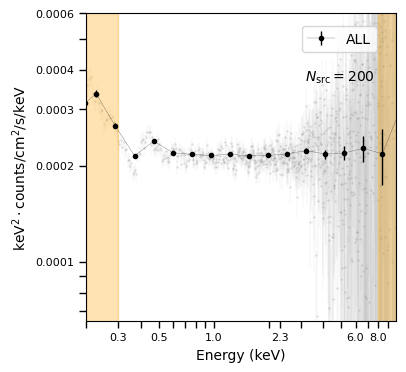

In [2]:
src_file_lst = [r'./data/po/src_demo_po.fits']
grp_file_lst = [r'./data/po/grp_src_demo_po.fits']
bkg_file_lst = [r'./data/po/bkg_demo_po.fits']
rmf_file_lst = [r'./data/po/demo_po_SHP.rmf']
arf_file_lst = [r'./data/po/demo_po_SHP.arf']

legend_lst = [r'ALL',]
color_lst = ['k']
alpha_lst = [1.0]
Nsrc_lst = []

for arf_file in arf_file_lst:
    with fits.open(arf_file) as hdu:
        arfscal = hdu['ARFSCAL'].data
    Nsrc_lst.append(r'$N_\text{src}=%d$'%len(arfscal))

fig, ax = plt.subplots(1,1,figsize=(4,4))
# fig_name = 'demo_po'
    
for i in range(len(src_file_lst)):
    src_file = src_file_lst[i]
    grp_file = grp_file_lst[i]
    bkg_file = bkg_file_lst[i]
    rmf_file = rmf_file_lst[i]
    arf_file = arf_file_lst[i]
    
    legend = legend_lst[i]
    color = color_lst[i]
    alpha = alpha_lst[i]
    
    with fits.open(src_file) as hdu:
        data = hdu[1].data
    chan = data['CHANNEL']
    pha = data['COUNTS']
    phaerr = data['STAT_ERR']
    
    with fits.open(bkg_file) as hdu:
        data = hdu[1].data
        head = hdu[1].header
    chan = data['CHANNEL']
    bkgpha = data['COUNTS']
    bkgphaerr = data['STAT_ERR']
    expo = head['EXPOSURE']
    
    with fits.open(rmf_file) as hdu:
        ebo = hdu[2].data
    ene_lo = ebo['E_MIN']
    ene_hi = ebo['E_MAX']
    ene_ce = (ene_lo + ene_hi) / 2
    ene_wd = ene_hi - ene_lo
    
    eene = np.logspace(np.log10(0.2),np.log10(ene_ce.max()),18)
    eelo = eene[:-1]
    eehi = eene[1:]
    make_grpflg(src_file,grp_file,method='EDGE',rmf_file=rmf_file,eelo=eelo,eehi=eehi)
    
    with fits.open(grp_file) as hdu:
        data = hdu[1].data
    grpflg = data['GROUPING']
    grpene_lo,grpene_hi,grppha,grpphaerr = rebin_pha(ene_lo,ene_hi,pha,phaerr,grpflg)
    grpene_lo,grpene_hi,grpbkgpha,grpbkgphaerr = rebin_pha(ene_lo,ene_hi,bkgpha,bkgphaerr,grpflg)
    grpene_wd = grpene_hi - grpene_lo
    grpene_ce = (grpene_lo + grpene_hi) / 2
    
    with fits.open(arf_file) as hdu:
        arf = hdu[1].data
    arfene_lo = arf['ENERG_LO']
    arfene_hi = arf['ENERG_HI']
    arfene_ce = (arfene_lo + arfene_hi) / 2
    arfene_wd = arfene_hi - arfene_lo
    specresp_coun = arf['SPECRESP']
    specresp_coun_ali = align_arf(ene_lo,ene_hi,arfene_lo,arfene_hi,specresp_coun)
    grpene_lo,grpene_hi,grpspecresp_coun = rebin_arf(arfene_lo,arfene_hi,specresp_coun,ene_lo,ene_hi,pha-bkgpha,grpflg)
    
    subtract = pha - bkgpha
    subtract_err = np.sqrt(phaerr**2 + bkgphaerr**2)
    ratio = subtract / specresp_coun_ali / ene_wd / expo
    ratio_err = subtract_err / specresp_coun_ali / ene_wd / expo
    ax.errorbar(ene_ce,ratio*ene_ce**2,yerr=(ratio_err*ene_ce**2),
                   fmt='o',ms=0.3,lw=0.1,c='gray',alpha=0.5,zorder=-5)
    
    subtract = grppha - grpbkgpha
    subtract_err = np.sqrt(grpphaerr**2 + grpbkgphaerr**2)
    ratio = subtract / grpspecresp_coun / grpene_wd / expo
    ratio_err = subtract_err / grpspecresp_coun / grpene_wd / expo
    ax.errorbar(grpene_ce,ratio*grpene_ce**2,yerr=(ratio_err*grpene_ce**2),
                   fmt='o-',ms=3.0,lw=0.15,c=color,capsize=0.,elinewidth=1.0,ecolor=color,alpha=alpha,zorder=1,
                   label=r'%s'%legend)

    ax.fill_betweenx(y=[6e-5,6e-4], x1=0.2, x2=0.3, color='orange', alpha=0.3, zorder=-1) 
    ax.fill_betweenx(y=[6e-5,6e-4], x1=8.0, x2=10.0, color='orange', alpha=0.3, zorder=-1) 
    #ax.text(0.57,0.85,r'\texttt{ARF weight: COUN}',transform=ax.transAxes,fontsize=9)
    #ax.text(0.93,0.84,'%s'%(LUV_lst[i]),transform=ax.transAxes,ha='right',fontsize=10,c=color)
    ax.text(0.93,0.78,'%s'%(Nsrc_lst[i]),transform=ax.transAxes,ha='right',fontsize=10,c=color)
    ax.legend(fontsize=10,loc='upper right',bbox_to_anchor=(0.96,0.98))
    ax.set_xscale('log')
    ax.set_xlim(0.2,10)
    x_ticks = [0.3, 0.5, 1.0, 2.3, 6.0, 8.0]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([str(x) for x in x_ticks])
    ax.set_xlabel('Energy (keV)',fontsize=10)
    ax.tick_params("x",which="major",
                  length=10,width = 1.0,size=5,labelsize=8,pad=3)
    ax.tick_params("x",which="minor",
                  length=10,width = 1.0,size=5,labelsize=8,pad=3)
    ax.set_ylim(6.5e-5,6e-4)
    ax.set_yscale('log')
    y_ticks = [1e-4,2e-4,3e-4,4e-4,6e-4]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([str(y) for y in y_ticks])
    ax.set_ylabel(r'keV$^2\cdot$counts/cm$^2$/s/keV',fontsize=10)
    ax.tick_params("y",which="major",
                  length=10,width = 1.0,size=5,labelsize=8)
    ax.tick_params("y",which="minor",
                  length=10,width = 1.0,size=5,labelsize=8)
    
    if i>0:
        ax.set_ylabel('')
        ax.set_yticklabels([])

plt.subplots_adjust(wspace=0.)
# plt.savefig('%s.png'%fig_name,bbox_inches='tight',transparent=False,dpi=300)

## **Step 4** (optional): Spectral fitting on other platform, e.g. XSPEC ... 

# **2. Other examples**
***Try for yourself!***

## **e.g.2**: absorbed powerlaw

The Galactic absorption is often an issue when studying the X-ray spectra of extragalactic sources (e.g. AGNs), suppressing the soft X-ray flux significantly.

<span style="font-family: 'Courier New', Courier, monospace; font-weight: 700;">Xstack</span> allows for correction of Galactic absorption, in order to study the intrinsic spectral shape unaffected by the Galactic medium. This is essentially done by multiplying the observed-frame ARF (effective area vs. input energy) with Galactic absorption profile (absorption factor vs. input energy), as an approach to account for the expected loss of effective area due to the absorption effect. To activate this correction, you will need to specify the NH value of each spectrum (`nh_lst`), as well as the sample Galactic absorption profile (`nh_file`).

In [11]:
# fetching data
with fits.open('./data/abspo/abspo_data.fits') as hdu:
    data = hdu[1].data
srcid_lst = data['srcid']
z_lst = data['z']
nh_lst = data['GalNH'] # in units of 1 cm^{-2}

phafile_lst = ['./data/abspo/abspo_spec/%s_abspo.fak'%srcid for srcid in srcid_lst]
bkgphafile_lst = ['./data/abspo/abspo_spec/%s_abspo_bkg.fak'%srcid for srcid in srcid_lst]
arffile_lst = ['./data/abspo/abspo_spec/%s_abspo.arf'%srcid for srcid in srcid_lst]
rmffile_lst = ['./data/abspo/abspo_spec/sample.rmf' for srcid in srcid_lst]

# initializing Xstack
data_abspo = XSTACK(phafile_lst=phafile_lst,
                    arffile_lst=arffile_lst,
                    rmffile_lst=rmffile_lst,
                    z_lst=z_lst,
                    bkgphafile_lst=bkgphafile_lst,
                    nh_lst=nh_lst,
                    srcid_lst=None,
                    arfscal_method='SHP',
                    int_rng=(1.0,2.3),
                    rmfsft_method='PAR',
                    sample_rmf=None,
                    sample_arf=None,
                    nh_file='../tbabs_1e20.txt',
                    Nbkggrp=10,
                    rm_ene_dsp=True,
                    o_pha_name='./data/abspo/src_demo_abspo.fits',
                    o_bkgpha_name='./data/abspo/bkg_demo_abspo.fits',
                    o_arf_name='./data/abspo/demo_abspo_SHP.arf',
                    o_rmf_name='./data/abspo/demo_abspo_SHP.rmf',
                    )

# run Xstack
data_abspo.run()

################### Shifting ... ######################


100%|██████████| 200/200 [00:26<00:00,  7.58it/s]


################### Stacking ... ######################
[ 5.25630476e-03  1.12854606e-03  5.67883066e-02  3.70221680e-03
  4.76546273e-03  8.61468272e-03  5.78356053e-03  2.57163076e-03
  4.53479885e-03  3.29259635e-03  1.13932575e-03  2.02808156e-03
  2.02949266e-03  2.92169039e-04  7.91795043e-03  8.30026935e-05
  5.28334321e-04  2.60638157e-03  1.45289776e-02  1.72899624e-03
  5.54065827e-04  1.80174034e-04  8.95338637e-04  1.36998249e-03
  3.67837719e-04  1.44288442e-03  1.12270772e-02  3.27576240e-02
  1.04531205e-02  1.13390589e-03  7.22103624e-03  2.25048174e-03
 -6.58168595e-05  7.61055284e-04  5.48341529e-04  3.66601234e-03
  7.70488700e-04  2.80475963e-04  1.63602705e-02  1.30724071e-03
  2.58178412e-04  1.41964249e-03  2.83511789e-03  2.51271933e-04
  1.71810127e-02  2.25950163e-03  1.16536716e-04  2.26744948e-03
  3.91651946e-03  1.83029726e-02  5.65683284e-03  2.36727905e-03
  3.02996553e-03  9.75566759e-03  2.02839427e-03  2.75323754e-02
  7.53016004e-04  7.99692069e-03  

/data/chensj/.conda/envs/Xstack/lib/python3.11/site-packages/Xstack/shift_rmf.py:221: RuntimeWarning: invalid value encountered in divide
  sum_prob /= np.sum(sum_prob,axis=1)[:,np.newaxis] # normalize
/data/chensj/.conda/envs/Xstack/lib/python3.11/site-packages/Xstack/shift_rmf.py:225: RuntimeWarning: invalid value encountered in divide
  sum_prob /= np.sum(sum_prob,axis=1)[:,np.newaxis] # renormalize


(array([ 0.,  0.,  0., ..., 19., 14.,  0.]),
 array([0.        , 0.        , 0.        , ..., 4.35889894, 3.74165739,
        0.        ]),
 array([ 0.        ,  0.        ,  0.        , ..., 20.12090161,
        20.76764488,  7.68905883]),
 array([0.        , 0.        , 0.        , ..., 0.69423706, 0.7053062 ,
        0.42916141]),
 array([ 0.        ,  0.        ,  0.        , ..., 30.99519168,
        30.75172246, 30.50491627]),
 array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.13110495, 0.12513113,
         0.11203183],
        [0.        , 0.        , 0.        , ..., 0.14683209, 0.15034943,
         0.14440411],
        [0.        , 0.        , 0.        , ..., 0.15396662, 0.164800

/data/chensj/.conda/envs/Xstack/lib/python3.11/site-packages/Xstack/misc.py:204: RuntimeWarning: invalid value encountered in divide
  grpspecresp.append((tmpspecresp * tmpwt / tmpwt.sum()).sum())
/data/chensj/.conda/envs/Xstack/lib/python3.11/site-packages/Xstack/misc.py:222: RuntimeWarning: invalid value encountered in divide
  grpspecresp.append((tmpspecresp * tmpwt / tmpwt.sum()).sum())
/tmp/ipykernel_96377/706062062.py:78: RuntimeWarning: invalid value encountered in divide
  ratio = subtract / specresp_coun_ali / ene_wd / expo
/tmp/ipykernel_96377/706062062.py:79: RuntimeWarning: invalid value encountered in divide
  ratio_err = subtract_err / specresp_coun_ali / ene_wd / expo


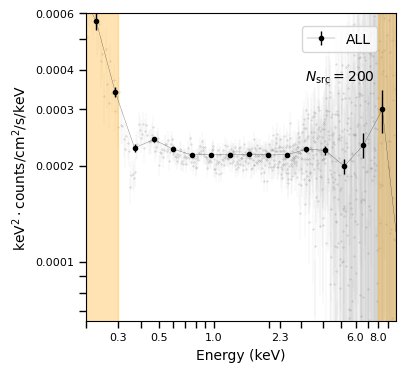

In [13]:
# plot your results
src_file_lst = [r'./data/abspo/src_demo_abspo.fits']
grp_file_lst = [r'./data/abspo/grp_src_demo_abspo.fits']
bkg_file_lst = [r'./data/abspo/bkg_demo_abspo.fits']
rmf_file_lst = [r'./data/abspo/demo_abspo_SHP.rmf']
arf_file_lst = [r'./data/abspo/demo_abspo_SHP.arf']

legend_lst = [r'ALL',]
color_lst = ['k']
alpha_lst = [1.0]
Nsrc_lst = []

for arf_file in arf_file_lst:
    with fits.open(arf_file) as hdu:
        arfscal = hdu['ARFSCAL'].data
    Nsrc_lst.append(r'$N_\text{src}=%d$'%len(arfscal))

fig, ax = plt.subplots(1,1,figsize=(4,4))
# fig_name = 'demo_po'
    
for i in range(len(src_file_lst)):
    src_file = src_file_lst[i]
    grp_file = grp_file_lst[i]
    bkg_file = bkg_file_lst[i]
    rmf_file = rmf_file_lst[i]
    arf_file = arf_file_lst[i]
    
    legend = legend_lst[i]
    color = color_lst[i]
    alpha = alpha_lst[i]
    
    with fits.open(src_file) as hdu:
        data = hdu[1].data
    chan = data['CHANNEL']
    pha = data['COUNTS']
    phaerr = data['STAT_ERR']
    
    with fits.open(bkg_file) as hdu:
        data = hdu[1].data
        head = hdu[1].header
    chan = data['CHANNEL']
    bkgpha = data['COUNTS']
    bkgphaerr = data['STAT_ERR']
    expo = head['EXPOSURE']
    
    with fits.open(rmf_file) as hdu:
        ebo = hdu[2].data
    ene_lo = ebo['E_MIN']
    ene_hi = ebo['E_MAX']
    ene_ce = (ene_lo + ene_hi) / 2
    ene_wd = ene_hi - ene_lo
    
    eene = np.logspace(np.log10(0.2),np.log10(ene_ce.max()),18)
    eelo = eene[:-1]
    eehi = eene[1:]
    make_grpflg(src_file,grp_file,method='EDGE',rmf_file=rmf_file,eelo=eelo,eehi=eehi)
    
    with fits.open(grp_file) as hdu:
        data = hdu[1].data
    grpflg = data['GROUPING']
    grpene_lo,grpene_hi,grppha,grpphaerr = rebin_pha(ene_lo,ene_hi,pha,phaerr,grpflg)
    grpene_lo,grpene_hi,grpbkgpha,grpbkgphaerr = rebin_pha(ene_lo,ene_hi,bkgpha,bkgphaerr,grpflg)
    grpene_wd = grpene_hi - grpene_lo
    grpene_ce = (grpene_lo + grpene_hi) / 2
    
    with fits.open(arf_file) as hdu:
        arf = hdu[1].data
    arfene_lo = arf['ENERG_LO']
    arfene_hi = arf['ENERG_HI']
    arfene_ce = (arfene_lo + arfene_hi) / 2
    arfene_wd = arfene_hi - arfene_lo
    specresp_coun = arf['SPECRESP']
    specresp_coun_ali = align_arf(ene_lo,ene_hi,arfene_lo,arfene_hi,specresp_coun)
    grpene_lo,grpene_hi,grpspecresp_coun = rebin_arf(arfene_lo,arfene_hi,specresp_coun,ene_lo,ene_hi,pha-bkgpha,grpflg)
    
    subtract = pha - bkgpha
    subtract_err = np.sqrt(phaerr**2 + bkgphaerr**2)
    ratio = subtract / specresp_coun_ali / ene_wd / expo
    ratio_err = subtract_err / specresp_coun_ali / ene_wd / expo
    ax.errorbar(ene_ce,ratio*ene_ce**2,yerr=(ratio_err*ene_ce**2),
                   fmt='o',ms=0.3,lw=0.1,c='gray',alpha=0.5,zorder=-5)
    
    subtract = grppha - grpbkgpha
    subtract_err = np.sqrt(grpphaerr**2 + grpbkgphaerr**2)
    ratio = subtract / grpspecresp_coun / grpene_wd / expo
    ratio_err = subtract_err / grpspecresp_coun / grpene_wd / expo
    ax.errorbar(grpene_ce,ratio*grpene_ce**2,yerr=(ratio_err*grpene_ce**2),
                   fmt='o-',ms=3.0,lw=0.15,c=color,capsize=0.,elinewidth=1.0,ecolor=color,alpha=alpha,zorder=1,
                   label=r'%s'%legend)

    ax.fill_betweenx(y=[6e-5,6e-4], x1=0.2, x2=0.3, color='orange', alpha=0.3, zorder=-1) 
    ax.fill_betweenx(y=[6e-5,6e-4], x1=8.0, x2=10.0, color='orange', alpha=0.3, zorder=-1) 
    ax.text(0.93,0.78,'%s'%(Nsrc_lst[i]),transform=ax.transAxes,ha='right',fontsize=10,c=color)
    ax.legend(fontsize=10,loc='upper right',bbox_to_anchor=(0.96,0.98))
    ax.set_xscale('log')
    ax.set_xlim(0.2,10)
    x_ticks = [0.3, 0.5, 1.0, 2.3, 6.0, 8.0]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([str(x) for x in x_ticks])
    ax.set_xlabel('Energy (keV)',fontsize=10)
    ax.tick_params("x",which="major",
                  length=10,width = 1.0,size=5,labelsize=8,pad=3)
    ax.tick_params("x",which="minor",
                  length=10,width = 1.0,size=5,labelsize=8,pad=3)
    ax.set_ylim(6.5e-5,6e-4)
    ax.set_yscale('log')
    y_ticks = [1e-4,2e-4,3e-4,4e-4,6e-4]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([str(y) for y in y_ticks])
    ax.set_ylabel(r'keV$^2\cdot$counts/cm$^2$/s/keV',fontsize=10)
    ax.tick_params("y",which="major",
                  length=10,width = 1.0,size=5,labelsize=8)
    ax.tick_params("y",which="minor",
                  length=10,width = 1.0,size=5,labelsize=8)
    
    if i>0:
        ax.set_ylabel('')
        ax.set_yticklabels([])

plt.subplots_adjust(wspace=0.)
# plt.savefig('%s.png'%fig_name,bbox_inches='tight',transparent=False,dpi=300)

## **e.g.3**: primary continuum (powerlaw) + soft excess (bbody)

In [15]:
# fetching data
with fits.open('./data/pobb/pobb_data.fits') as hdu:
    data = hdu[1].data
srcid_lst = data['srcid']
z_lst = data['z']

phafile_lst = ['./data/pobb/pobb_spec/%s_pobb.fak'%srcid for srcid in srcid_lst]
bkgphafile_lst = ['./data/pobb/pobb_spec/%s_pobb_bkg.fak'%srcid for srcid in srcid_lst]
arffile_lst = ['./data/pobb/pobb_spec/%s_pobb.arf'%srcid for srcid in srcid_lst]
rmffile_lst = ['./data/pobb/pobb_spec/sample.rmf' for srcid in srcid_lst]

# initializing Xstack
data_pobb = XSTACK(phafile_lst=phafile_lst,
                   arffile_lst=arffile_lst,
                   rmffile_lst=rmffile_lst,
                   z_lst=z_lst,
                   bkgphafile_lst=bkgphafile_lst,
                   nh_lst=None,
                   srcid_lst=None,
                   arfscal_method='SHP',
                   int_rng=(1.0,2.3),
                   rmfsft_method='PAR',
                   sample_rmf=None,
                   sample_arf=None,
                   nh_file=None,
                   Nbkggrp=10,
                   rm_ene_dsp=True,
                   o_pha_name='./data/pobb/src_demo_pobb.fits',
                   o_bkgpha_name='./data/pobb/bkg_demo_pobb.fits',
                   o_arf_name='./data/pobb/demo_pobb_SHP.arf',
                   o_rmf_name='./data/pobb/demo_pobb_SHP.rmf',
                   )

# run Xstack
data_pobb.run()

################### Shifting ... ######################


100%|██████████| 200/200 [00:21<00:00,  9.31it/s]


################### Stacking ... ######################
[4.42043547e-03 8.46589614e-04 6.04194009e-02 3.30464578e-03
 4.72181050e-03 8.45229481e-03 5.76480932e-03 2.32927772e-03
 4.65958106e-03 3.03310839e-03 1.16199460e-03 2.03066279e-03
 2.00863571e-03 1.72621504e-04 6.54011543e-03 6.73358856e-04
 6.56861297e-04 2.99870740e-03 1.28122621e-02 1.48252002e-03
 3.95891747e-04 1.14980466e-04 1.05204130e-03 1.71466308e-03
 3.48007519e-04 1.49373771e-03 1.18777486e-02 3.38324235e-02
 1.11206973e-02 1.12330508e-03 8.15774172e-03 2.17841254e-03
 7.08734843e-04 7.96356150e-04 6.32545822e-04 3.46300844e-03
 3.25317690e-04 6.81810619e-04 1.55701298e-02 1.30496798e-03
 1.83073313e-04 1.74493843e-03 3.28434002e-03 3.14553466e-04
 1.57577629e-02 1.70772340e-03 9.72886809e-05 1.97602844e-03
 4.14023956e-03 1.85076519e-02 5.91818155e-03 2.14378074e-03
 2.85385268e-03 8.27212629e-03 1.68274659e-03 2.69129186e-02
 1.00467254e-03 7.88797049e-03 6.61458835e-04 8.76962784e-04
 1.53664384e-02 3.54209760e-0

/data/chensj/.conda/envs/Xstack/lib/python3.11/site-packages/Xstack/shift_rmf.py:221: RuntimeWarning: invalid value encountered in divide
  sum_prob /= np.sum(sum_prob,axis=1)[:,np.newaxis] # normalize
/data/chensj/.conda/envs/Xstack/lib/python3.11/site-packages/Xstack/shift_rmf.py:225: RuntimeWarning: invalid value encountered in divide
  sum_prob /= np.sum(sum_prob,axis=1)[:,np.newaxis] # renormalize


(array([ 0.,  0.,  0., ..., 16., 17.,  0.]),
 array([0.        , 0.        , 0.        , ..., 4.        , 4.12310563,
        0.        ]),
 array([ 0.        ,  0.        ,  0.        , ..., 20.38438961,
        21.10299324,  8.55138319]),
 array([0.        , 0.        , 0.        , ..., 0.69876788, 0.71097791,
        0.45258719]),
 array([ 0.        ,  0.        ,  0.        , ..., 31.8319505 ,
        31.58522163, 31.33512222]),
 array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.13098307, 0.1250159 ,
         0.11194151],
        [0.        , 0.        , 0.        , ..., 0.14669786, 0.15020771,
         0.14427935],
        [0.        , 0.        , 0.        , ..., 0.15372097, 0.164538

/data/chensj/.conda/envs/Xstack/lib/python3.11/site-packages/Xstack/misc.py:204: RuntimeWarning: invalid value encountered in divide
  grpspecresp.append((tmpspecresp * tmpwt / tmpwt.sum()).sum())
/data/chensj/.conda/envs/Xstack/lib/python3.11/site-packages/Xstack/misc.py:222: RuntimeWarning: invalid value encountered in divide
  grpspecresp.append((tmpspecresp * tmpwt / tmpwt.sum()).sum())
/tmp/ipykernel_96377/256114900.py:78: RuntimeWarning: invalid value encountered in divide
  ratio = subtract / specresp_coun_ali / ene_wd / expo
/tmp/ipykernel_96377/256114900.py:79: RuntimeWarning: invalid value encountered in divide
  ratio_err = subtract_err / specresp_coun_ali / ene_wd / expo


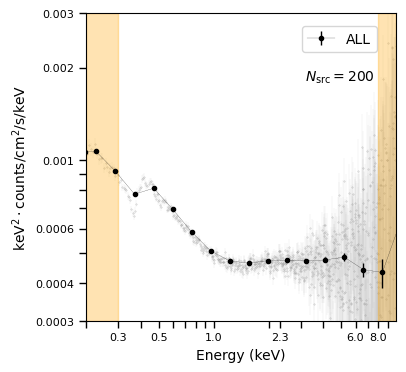

In [19]:
# plot your results
src_file_lst = [r'./data/pobb/src_demo_pobb.fits']
grp_file_lst = [r'./data/pobb/grp_src_demo_pobb.fits']
bkg_file_lst = [r'./data/pobb/bkg_demo_pobb.fits']
rmf_file_lst = [r'./data/pobb/demo_pobb_SHP.rmf']
arf_file_lst = [r'./data/pobb/demo_pobb_SHP.arf']

legend_lst = [r'ALL',]
color_lst = ['k']
alpha_lst = [1.0]
Nsrc_lst = []

for arf_file in arf_file_lst:
    with fits.open(arf_file) as hdu:
        arfscal = hdu['ARFSCAL'].data
    Nsrc_lst.append(r'$N_\text{src}=%d$'%len(arfscal))

fig, ax = plt.subplots(1,1,figsize=(4,4))
# fig_name = 'demo_po'
    
for i in range(len(src_file_lst)):
    src_file = src_file_lst[i]
    grp_file = grp_file_lst[i]
    bkg_file = bkg_file_lst[i]
    rmf_file = rmf_file_lst[i]
    arf_file = arf_file_lst[i]
    
    legend = legend_lst[i]
    color = color_lst[i]
    alpha = alpha_lst[i]
    
    with fits.open(src_file) as hdu:
        data = hdu[1].data
    chan = data['CHANNEL']
    pha = data['COUNTS']
    phaerr = data['STAT_ERR']
    
    with fits.open(bkg_file) as hdu:
        data = hdu[1].data
        head = hdu[1].header
    chan = data['CHANNEL']
    bkgpha = data['COUNTS']
    bkgphaerr = data['STAT_ERR']
    expo = head['EXPOSURE']
    
    with fits.open(rmf_file) as hdu:
        ebo = hdu[2].data
    ene_lo = ebo['E_MIN']
    ene_hi = ebo['E_MAX']
    ene_ce = (ene_lo + ene_hi) / 2
    ene_wd = ene_hi - ene_lo
    
    eene = np.logspace(np.log10(0.2),np.log10(ene_ce.max()),18)
    eelo = eene[:-1]
    eehi = eene[1:]
    make_grpflg(src_file,grp_file,method='EDGE',rmf_file=rmf_file,eelo=eelo,eehi=eehi)
    
    with fits.open(grp_file) as hdu:
        data = hdu[1].data
    grpflg = data['GROUPING']
    grpene_lo,grpene_hi,grppha,grpphaerr = rebin_pha(ene_lo,ene_hi,pha,phaerr,grpflg)
    grpene_lo,grpene_hi,grpbkgpha,grpbkgphaerr = rebin_pha(ene_lo,ene_hi,bkgpha,bkgphaerr,grpflg)
    grpene_wd = grpene_hi - grpene_lo
    grpene_ce = (grpene_lo + grpene_hi) / 2
    
    with fits.open(arf_file) as hdu:
        arf = hdu[1].data
    arfene_lo = arf['ENERG_LO']
    arfene_hi = arf['ENERG_HI']
    arfene_ce = (arfene_lo + arfene_hi) / 2
    arfene_wd = arfene_hi - arfene_lo
    specresp_coun = arf['SPECRESP']
    specresp_coun_ali = align_arf(ene_lo,ene_hi,arfene_lo,arfene_hi,specresp_coun)
    grpene_lo,grpene_hi,grpspecresp_coun = rebin_arf(arfene_lo,arfene_hi,specresp_coun,ene_lo,ene_hi,pha-bkgpha,grpflg)
    
    subtract = pha - bkgpha
    subtract_err = np.sqrt(phaerr**2 + bkgphaerr**2)
    ratio = subtract / specresp_coun_ali / ene_wd / expo
    ratio_err = subtract_err / specresp_coun_ali / ene_wd / expo
    ax.errorbar(ene_ce,ratio*ene_ce**2,yerr=(ratio_err*ene_ce**2),
                   fmt='o',ms=0.3,lw=0.1,c='gray',alpha=0.5,zorder=-5)
    
    subtract = grppha - grpbkgpha
    subtract_err = np.sqrt(grpphaerr**2 + grpbkgphaerr**2)
    ratio = subtract / grpspecresp_coun / grpene_wd / expo
    ratio_err = subtract_err / grpspecresp_coun / grpene_wd / expo
    ax.errorbar(grpene_ce,ratio*grpene_ce**2,yerr=(ratio_err*grpene_ce**2),
                   fmt='o-',ms=3.0,lw=0.15,c=color,capsize=0.,elinewidth=1.0,ecolor=color,alpha=alpha,zorder=1,
                   label=r'%s'%legend)

    ax.fill_betweenx(y=[3e-4,3e-3], x1=0.2, x2=0.3, color='orange', alpha=0.3, zorder=-1) 
    ax.fill_betweenx(y=[3e-4,3e-3], x1=8.0, x2=10.0, color='orange', alpha=0.3, zorder=-1) 
    ax.text(0.93,0.78,'%s'%(Nsrc_lst[i]),transform=ax.transAxes,ha='right',fontsize=10,c=color)
    ax.legend(fontsize=10,loc='upper right',bbox_to_anchor=(0.96,0.98))
    ax.set_xscale('log')
    ax.set_xlim(0.2,10)
    x_ticks = [0.3, 0.5, 1.0, 2.3, 6.0, 8.0]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([str(x) for x in x_ticks])
    ax.set_xlabel('Energy (keV)',fontsize=10)
    ax.tick_params("x",which="major",
                  length=10,width = 1.0,size=5,labelsize=8,pad=3)
    ax.tick_params("x",which="minor",
                  length=10,width = 1.0,size=5,labelsize=8,pad=3)
    ax.set_ylim(3e-4,3e-3)
    ax.set_yscale('log')
    y_ticks = [3e-4,4e-4,6e-4,1e-3,2e-3,3e-3]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([str(y) for y in y_ticks])
    ax.set_ylabel(r'keV$^2\cdot$counts/cm$^2$/s/keV',fontsize=10)
    ax.tick_params("y",which="major",
                  length=10,width = 1.0,size=5,labelsize=8)
    ax.tick_params("y",which="minor",
                  length=10,width = 1.0,size=5,labelsize=8)
    
    if i>0:
        ax.set_ylabel('')
        ax.set_yticklabels([])

plt.subplots_adjust(wspace=0.)
# plt.savefig('%s.png'%fig_name,bbox_inches='tight',transparent=False,dpi=300)

## **e.g.4**: absorbed primary continuum (powerlaw) + soft excess (bbody)

In [21]:
# fetching data
with fits.open('./data/abspobb/abspobb_data.fits') as hdu:
    data = hdu[1].data
srcid_lst = data['srcid']
z_lst = data['z']
nh_lst = data['GalNH'] # in units of 1 cm^{-2}

phafile_lst = ['./data/abspobb/abspobb_spec/%s_abspobb.fak'%srcid for srcid in srcid_lst]
bkgphafile_lst = ['./data/abspobb/abspobb_spec/%s_abspobb_bkg.fak'%srcid for srcid in srcid_lst]
arffile_lst = ['./data/abspobb/abspobb_spec/%s_abspobb.arf'%srcid for srcid in srcid_lst]
rmffile_lst = ['./data/abspobb/abspobb_spec/sample.rmf' for srcid in srcid_lst]

# initializing Xstack
data_abspobb = XSTACK(phafile_lst=phafile_lst,
                      arffile_lst=arffile_lst,
                      rmffile_lst=rmffile_lst,
                      z_lst=z_lst,
                      bkgphafile_lst=bkgphafile_lst,
                      nh_lst=nh_lst,
                      srcid_lst=None,
                      arfscal_method='SHP',
                      int_rng=(1.0,2.3),
                      rmfsft_method='PAR',
                      sample_rmf=None,
                      sample_arf=None,
                      nh_file='../tbabs_1e20.txt',
                      Nbkggrp=10,
                      rm_ene_dsp=True,
                      o_pha_name='./data/abspobb/src_demo_abspobb.fits',
                      o_bkgpha_name='./data/abspobb/bkg_demo_abspobb.fits',
                      o_arf_name='./data/abspobb/demo_abspobb_SHP.arf',
                      o_rmf_name='./data/abspobb/demo_abspobb_SHP.rmf',
                      )

# run Xstack
data_abspobb.run()

################### Shifting ... ######################


100%|██████████| 200/200 [00:25<00:00,  7.73it/s]


################### Stacking ... ######################
[ 4.46079282e-03  8.87792345e-04  6.27631373e-02  3.22011709e-03
  4.63792934e-03  8.51149680e-03  6.37321569e-03  2.74377601e-03
  4.98265596e-03  3.03093717e-03  1.30819657e-03  2.03428842e-03
  1.96112419e-03  2.06176554e-04  7.19332172e-03  3.67292341e-04
  6.44157224e-04  2.95632792e-03  1.35329513e-02  1.60574008e-03
  3.83330899e-04  1.46151395e-04  1.20248519e-03  1.49344003e-03
  3.44161003e-04  1.58398300e-03  1.13471488e-02  3.34421630e-02
  1.08095340e-02  1.19094683e-03  8.15472770e-03  1.89975461e-03
  2.67727279e-04  8.42619594e-04  6.17499861e-04  3.45920226e-03
  3.83215754e-04  4.87012170e-04  1.58405368e-02  1.29637085e-03
  2.20657759e-04  1.80743142e-03  3.09922917e-03  2.89416131e-04
  1.58657909e-02  1.83358543e-03  1.15551635e-04  1.91516834e-03
  4.00449537e-03  1.83177640e-02  5.99554270e-03  2.36653200e-03
  2.87300908e-03  8.56077165e-03  1.76932193e-03  2.81284001e-02
  9.48374975e-04  8.17094582e-03  

/data/chensj/.conda/envs/Xstack/lib/python3.11/site-packages/Xstack/shift_rmf.py:221: RuntimeWarning: invalid value encountered in divide
  sum_prob /= np.sum(sum_prob,axis=1)[:,np.newaxis] # normalize
/data/chensj/.conda/envs/Xstack/lib/python3.11/site-packages/Xstack/shift_rmf.py:225: RuntimeWarning: invalid value encountered in divide
  sum_prob /= np.sum(sum_prob,axis=1)[:,np.newaxis] # renormalize


(array([ 0.,  0.,  0., ..., 15., 29.,  1.]),
 array([0.        , 0.        , 0.        , ..., 3.87298335, 5.38516481,
        1.        ]),
 array([ 0.        ,  0.        ,  0.        , ..., 20.00113434,
        20.31252925,  8.38370901]),
 array([0.        , 0.        , 0.        , ..., 0.6921678 , 0.69753512,
        0.4481281 ]),
 array([ 0.        ,  0.        ,  0.        , ..., 31.30636365,
        31.06194657, 30.81413142]),
 array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.13108228, 0.12510354,
         0.11200147],
        [0.        , 0.        , 0.        , ..., 0.14680878, 0.15032375,
         0.14437759],
        [0.        , 0.        , 0.        , ..., 0.15387069, 0.164694

/data/chensj/.conda/envs/Xstack/lib/python3.11/site-packages/Xstack/misc.py:204: RuntimeWarning: invalid value encountered in divide
  grpspecresp.append((tmpspecresp * tmpwt / tmpwt.sum()).sum())
/data/chensj/.conda/envs/Xstack/lib/python3.11/site-packages/Xstack/misc.py:222: RuntimeWarning: invalid value encountered in divide
  grpspecresp.append((tmpspecresp * tmpwt / tmpwt.sum()).sum())
/tmp/ipykernel_96377/4208496652.py:78: RuntimeWarning: invalid value encountered in divide
  ratio = subtract / specresp_coun_ali / ene_wd / expo
/tmp/ipykernel_96377/4208496652.py:79: RuntimeWarning: invalid value encountered in divide
  ratio_err = subtract_err / specresp_coun_ali / ene_wd / expo


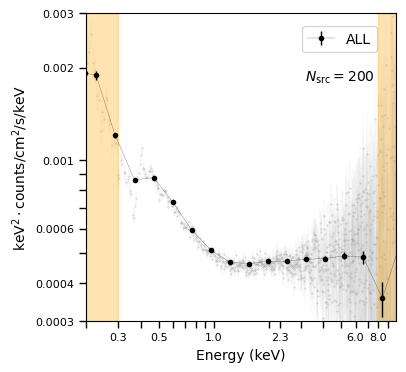

In [22]:
# plot your results
src_file_lst = [r'./data/abspobb/src_demo_abspobb.fits']
grp_file_lst = [r'./data/abspobb/grp_src_demo_abspobb.fits']
bkg_file_lst = [r'./data/abspobb/bkg_demo_abspobb.fits']
rmf_file_lst = [r'./data/abspobb/demo_abspobb_SHP.rmf']
arf_file_lst = [r'./data/abspobb/demo_abspobb_SHP.arf']

legend_lst = [r'ALL',]
color_lst = ['k']
alpha_lst = [1.0]
Nsrc_lst = []

for arf_file in arf_file_lst:
    with fits.open(arf_file) as hdu:
        arfscal = hdu['ARFSCAL'].data
    Nsrc_lst.append(r'$N_\text{src}=%d$'%len(arfscal))

fig, ax = plt.subplots(1,1,figsize=(4,4))
# fig_name = 'demo_po'
    
for i in range(len(src_file_lst)):
    src_file = src_file_lst[i]
    grp_file = grp_file_lst[i]
    bkg_file = bkg_file_lst[i]
    rmf_file = rmf_file_lst[i]
    arf_file = arf_file_lst[i]
    
    legend = legend_lst[i]
    color = color_lst[i]
    alpha = alpha_lst[i]
    
    with fits.open(src_file) as hdu:
        data = hdu[1].data
    chan = data['CHANNEL']
    pha = data['COUNTS']
    phaerr = data['STAT_ERR']
    
    with fits.open(bkg_file) as hdu:
        data = hdu[1].data
        head = hdu[1].header
    chan = data['CHANNEL']
    bkgpha = data['COUNTS']
    bkgphaerr = data['STAT_ERR']
    expo = head['EXPOSURE']
    
    with fits.open(rmf_file) as hdu:
        ebo = hdu[2].data
    ene_lo = ebo['E_MIN']
    ene_hi = ebo['E_MAX']
    ene_ce = (ene_lo + ene_hi) / 2
    ene_wd = ene_hi - ene_lo
    
    eene = np.logspace(np.log10(0.2),np.log10(ene_ce.max()),18)
    eelo = eene[:-1]
    eehi = eene[1:]
    make_grpflg(src_file,grp_file,method='EDGE',rmf_file=rmf_file,eelo=eelo,eehi=eehi)
    
    with fits.open(grp_file) as hdu:
        data = hdu[1].data
    grpflg = data['GROUPING']
    grpene_lo,grpene_hi,grppha,grpphaerr = rebin_pha(ene_lo,ene_hi,pha,phaerr,grpflg)
    grpene_lo,grpene_hi,grpbkgpha,grpbkgphaerr = rebin_pha(ene_lo,ene_hi,bkgpha,bkgphaerr,grpflg)
    grpene_wd = grpene_hi - grpene_lo
    grpene_ce = (grpene_lo + grpene_hi) / 2
    
    with fits.open(arf_file) as hdu:
        arf = hdu[1].data
    arfene_lo = arf['ENERG_LO']
    arfene_hi = arf['ENERG_HI']
    arfene_ce = (arfene_lo + arfene_hi) / 2
    arfene_wd = arfene_hi - arfene_lo
    specresp_coun = arf['SPECRESP']
    specresp_coun_ali = align_arf(ene_lo,ene_hi,arfene_lo,arfene_hi,specresp_coun)
    grpene_lo,grpene_hi,grpspecresp_coun = rebin_arf(arfene_lo,arfene_hi,specresp_coun,ene_lo,ene_hi,pha-bkgpha,grpflg)
    
    subtract = pha - bkgpha
    subtract_err = np.sqrt(phaerr**2 + bkgphaerr**2)
    ratio = subtract / specresp_coun_ali / ene_wd / expo
    ratio_err = subtract_err / specresp_coun_ali / ene_wd / expo
    ax.errorbar(ene_ce,ratio*ene_ce**2,yerr=(ratio_err*ene_ce**2),
                   fmt='o',ms=0.3,lw=0.1,c='gray',alpha=0.5,zorder=-5)
    
    subtract = grppha - grpbkgpha
    subtract_err = np.sqrt(grpphaerr**2 + grpbkgphaerr**2)
    ratio = subtract / grpspecresp_coun / grpene_wd / expo
    ratio_err = subtract_err / grpspecresp_coun / grpene_wd / expo
    ax.errorbar(grpene_ce,ratio*grpene_ce**2,yerr=(ratio_err*grpene_ce**2),
                   fmt='o-',ms=3.0,lw=0.15,c=color,capsize=0.,elinewidth=1.0,ecolor=color,alpha=alpha,zorder=1,
                   label=r'%s'%legend)

    ax.fill_betweenx(y=[3e-4,3e-3], x1=0.2, x2=0.3, color='orange', alpha=0.3, zorder=-1) 
    ax.fill_betweenx(y=[3e-4,3e-3], x1=8.0, x2=10.0, color='orange', alpha=0.3, zorder=-1) 
    ax.text(0.93,0.78,'%s'%(Nsrc_lst[i]),transform=ax.transAxes,ha='right',fontsize=10,c=color)
    ax.legend(fontsize=10,loc='upper right',bbox_to_anchor=(0.96,0.98))
    ax.set_xscale('log')
    ax.set_xlim(0.2,10)
    x_ticks = [0.3, 0.5, 1.0, 2.3, 6.0, 8.0]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([str(x) for x in x_ticks])
    ax.set_xlabel('Energy (keV)',fontsize=10)
    ax.tick_params("x",which="major",
                  length=10,width = 1.0,size=5,labelsize=8,pad=3)
    ax.tick_params("x",which="minor",
                  length=10,width = 1.0,size=5,labelsize=8,pad=3)
    ax.set_ylim(3e-4,3e-3)
    ax.set_yscale('log')
    y_ticks = [3e-4,4e-4,6e-4,1e-3,2e-3,3e-3]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([str(y) for y in y_ticks])
    ax.set_ylabel(r'keV$^2\cdot$counts/cm$^2$/s/keV',fontsize=10)
    ax.tick_params("y",which="major",
                  length=10,width = 1.0,size=5,labelsize=8)
    ax.tick_params("y",which="minor",
                  length=10,width = 1.0,size=5,labelsize=8)
    
    if i>0:
        ax.set_ylabel('')
        ax.set_yticklabels([])

plt.subplots_adjust(wspace=0.)
# plt.savefig('%s.png'%fig_name,bbox_inches='tight',transparent=False,dpi=300)

# **3. (optional) Generate some fake spectra**

## single powerlaws

In [8]:
Nspec = 200
np.random.seed(1)   # set seed for np.random

rand = np.random.rand(Nspec*3)
z_lst = 0.3 + 1.7*rand[:Nspec]
tlum_int_lst = 44.5 + rand[Nspec:2*Nspec]
gamma_lst = 1.9 + 0.2*rand[2*Nspec:3*Nspec]
srcid_lst = np.arange(Nspec)
srcid_lst = np.array(['{:05d}'.format(srcid) for srcid in srcid_lst])

# write fits file to store basic data
names = ['srcid','z']
formats = ['A10','D']
arrays = [srcid_lst,z_lst]
columns = [fits.Column(name=name_,format=format_,array=array_) for name_,format_,array_ in zip(names,formats,arrays)]
coldefs = fits.ColDefs(columns)
table = fits.BinTableHDU.from_columns(coldefs)
table.writeto('./data/po/po_data.fits',overwrite=True)

# generate fake spectra
out_dir = os.getcwd() + '/data/po/po_spec'
log_dir = os.getcwd() + '/data/po/po_log'
os.system('rm -rf %s'%out_dir)
os.system('rm -rf %s'%log_dir)

for i in tqdm(range(Nspec)):
    srcid = srcid_lst[i]
    z = z_lst[i]
    #pclum = pclum_lst[i]
    gamma = gamma_lst[i]
    alpha = gamma - 1    # F_E~E^{-alpha}, where F_E in units of erg/s/cm^2
    tlum_int = tlum_int_lst[i]

    out_pre = srcid + '_po'
    seed = i
    src_expo = 2000
    bkg_expo = 2000

    spec_dir = os.getcwd() + '/data'
    src_file = os.getcwd() + '/data/sample.src'
    arf_file = os.getcwd() + '/data/sample.arf'
    rmf_file = os.getcwd() + '/data/sample.rmf'

    make_fkspec('po',[z,tlum_int,gamma],seed,spec_dir,src_file,arf_file,out_pre,out_dir,log_dir,src_expo=src_expo,bkg_expo=bkg_expo)
    #make_fkspec('po',[z,tlum_int,gamma],seed,spec_dir,src_file,arf_file,out_pre,out_dir,log_dir,src_expo=src_expo,bkg_expo=bkg_expo,run_sh=False,pipeline_file='pipeline_po.sh')

os.system('cp ./data/sample.rmf ./data/po/po_spec')

100%|██████████| 200/200 [01:37<00:00,  2.04it/s]


0

## single absorbed powerlaw

In [8]:
Nspec = 200
np.random.seed(1)   # set seed for np.random

rand = np.random.rand(Nspec*4)
z_lst = 0.3 + 1.7*rand[:Nspec]
tlum_int_lst = 44.5 + rand[Nspec:2*Nspec]
gamma_lst = 1.9 + 0.2*rand[2*Nspec:3*Nspec]
nh_lst = 0.1*rand[3*Nspec:] # in units of 1e22 cm^{-2}
srcid_lst = np.arange(Nspec)
srcid_lst = np.array(['{:05d}'.format(srcid) for srcid in srcid_lst])

# write fits file to store basic data
names = ['srcid','z','GalNH']
formats = ['A10','D','D']
arrays = [srcid_lst,z_lst,nh_lst*1e22]
columns = [fits.Column(name=name_,format=format_,array=array_) for name_,format_,array_ in zip(names,formats,arrays)]
coldefs = fits.ColDefs(columns)
table = fits.BinTableHDU.from_columns(coldefs)
table.writeto('./data/abspo/abspo_data.fits',overwrite=True)

# generate fake spectra
out_dir = os.getcwd() + '/data/abspo/abspo_spec'
log_dir = os.getcwd() + '/data/abspo/abspo_log'
os.system('rm -rf %s'%out_dir)
os.system('rm -rf %s'%log_dir)

for i in tqdm(range(Nspec)):
    srcid = srcid_lst[i]
    z = z_lst[i]
    gamma = gamma_lst[i]
    alpha = gamma - 1    # F_E~E^{-alpha}, where F_E in units of erg/s/cm^2
    tlum_int = tlum_int_lst[i]
    nh = nh_lst[i]

    out_pre = srcid + '_abspo'
    seed = i
    src_expo = 2000
    bkg_expo = 2000

    spec_dir = os.getcwd() + '/data'
    src_file = os.getcwd() + '/data/sample.src'
    arf_file = os.getcwd() + '/data/sample.arf'
    rmf_file = os.getcwd() + '/data/sample.rmf'

    make_fkspec('abspo',[nh,z,tlum_int,gamma],seed,spec_dir,src_file,arf_file,out_pre,out_dir,log_dir,src_expo=src_expo,bkg_expo=bkg_expo)
    #make_fkspec('abspo',[nh,z,tlum_int,gamma],seed,spec_dir,src_file,arf_file,out_pre,out_dir,log_dir,src_expo=src_expo,bkg_expo=bkg_expo,run_sh=False,pipeline_file='pipeline_po.sh')

os.system('cp ./data/sample.rmf ./data/abspo/abspo_spec')

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [01:31<00:00,  2.19it/s]


0

## primary continuum (powerlaw) + soft excess (bbody)

In [14]:
Nspec = 200
np.random.seed(1)   # set seed for np.random

rand = np.random.rand(Nspec*4)
z_lst = 0.3 + 1.7*rand[:Nspec]
tlum_int_lst = 44.5 + rand[Nspec:2*Nspec]
gamma_lst = 1.9 + 0.2*rand[2*Nspec:3*Nspec]
q_lst = 0.4*rand[3*Nspec:]  # soft excess strength
srcid_lst = np.arange(Nspec)
srcid_lst = np.array(['{:05d}'.format(srcid) for srcid in srcid_lst])

# write fits file to store basic data
names = ['srcid','z','q']
formats = ['A10','D','D']
arrays = [srcid_lst,z_lst,q_lst]
columns = [fits.Column(name=name_,format=format_,array=array_) for name_,format_,array_ in zip(names,formats,arrays)]
coldefs = fits.ColDefs(columns)
table = fits.BinTableHDU.from_columns(coldefs)
table.writeto('./data/pobb/pobb_data.fits',overwrite=True)

# generate fake spectra
out_dir = os.getcwd() + '/data/pobb/pobb_spec'
log_dir = os.getcwd() + '/data/pobb/pobb_log'
os.system('rm -rf %s'%out_dir)
os.system('rm -rf %s'%log_dir)

for i in tqdm(range(Nspec)):
    srcid = srcid_lst[i]
    z = z_lst[i]
    gamma = gamma_lst[i]
    alpha = gamma - 1    # F_E~E^{-alpha}, where F_E in units of erg/s/cm^2
    tlum_int = tlum_int_lst[i]
    q = q_lst[i]

    out_pre = srcid + '_pobb'
    seed = i
    src_expo = 2000
    bkg_expo = 2000

    spec_dir = os.getcwd() + '/data'
    src_file = os.getcwd() + '/data/sample.src'
    arf_file = os.getcwd() + '/data/sample.arf'
    rmf_file = os.getcwd() + '/data/sample.rmf'

    make_fkspec('pobb',[z,tlum_int,gamma,q],seed,spec_dir,src_file,arf_file,out_pre,out_dir,log_dir,src_expo=src_expo,bkg_expo=bkg_expo)
    #make_fkspec('pobb',[z,tlum_int,gamma,q],seed,spec_dir,src_file,arf_file,out_pre,out_dir,log_dir,src_expo=src_expo,bkg_expo=bkg_expo,run_sh=False,pipeline_file='pipeline_po.sh')

os.system('cp ./data/sample.rmf ./data/pobb/pobb_spec')

100%|██████████| 200/200 [01:59<00:00,  1.68it/s]


0

## absorbed primary continuum (powerlaw) + soft excess (bbody)

In [20]:
Nspec = 200
np.random.seed(1)   # set seed for np.random

rand = np.random.rand(Nspec*5)
z_lst = 0.3 + 1.7*rand[:Nspec]
tlum_int_lst = 44.5 + rand[Nspec:2*Nspec]
gamma_lst = 1.9 + 0.2*rand[2*Nspec:3*Nspec]
nh_lst = 0.1*rand[3*Nspec:4*Nspec] # in units of 1e22 cm^{-2}
q_lst = 0.4*rand[4*Nspec:]  # soft excess strength
srcid_lst = np.arange(Nspec)
srcid_lst = np.array(['{:05d}'.format(srcid) for srcid in srcid_lst])

# write fits file to store basic data
names = ['srcid','z','GalNH']
formats = ['A10','D','D']
arrays = [srcid_lst,z_lst,nh_lst*1e22]
columns = [fits.Column(name=name_,format=format_,array=array_) for name_,format_,array_ in zip(names,formats,arrays)]
coldefs = fits.ColDefs(columns)
table = fits.BinTableHDU.from_columns(coldefs)
table.writeto('./data/abspobb/abspobb_data.fits',overwrite=True)

# generate fake spectra
out_dir = os.getcwd() + '/data/abspobb/abspobb_spec'
log_dir = os.getcwd() + '/data/abspobb/abspobb_log'
os.system('rm -rf %s'%out_dir)
os.system('rm -rf %s'%log_dir)

for i in tqdm(range(Nspec)):
    srcid = srcid_lst[i]
    z = z_lst[i]
    gamma = gamma_lst[i]
    alpha = gamma - 1    # F_E~E^{-alpha}, where F_E in units of erg/s/cm^2
    tlum_int = tlum_int_lst[i]
    q = q_lst[i]
    nh = nh_lst[i]

    out_pre = srcid + '_abspobb'
    seed = i
    src_expo = 2000
    bkg_expo = 2000

    spec_dir = os.getcwd() + '/data'
    src_file = os.getcwd() + '/data/sample.src'
    arf_file = os.getcwd() + '/data/sample.arf'
    rmf_file = os.getcwd() + '/data/sample.rmf'

    make_fkspec('abspobb',[nh,z,tlum_int,gamma,q],seed,spec_dir,src_file,arf_file,out_pre,out_dir,log_dir,src_expo=src_expo,bkg_expo=bkg_expo)
    #make_fkspec('abspobb',[nh,z,tlum_int,gamma],seed,spec_dir,src_file,arf_file,out_pre,out_dir,log_dir,src_expo=src_expo,bkg_expo=bkg_expo,run_sh=False,pipeline_file='pipeline_po.sh')

os.system('cp ./data/sample.rmf ./data/abspobb/abspobb_spec')

100%|██████████| 200/200 [03:21<00:00,  1.01s/it]


0